In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
train_csv_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/train.csv"  
train_images_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/"  

# Load train.csv
df_train = pd.read_csv(train_csv_path)

df_train["image_path"] = df_train["file_name"].apply(lambda x: os.path.join(train_images_path, x))
df_train.head()



,Unnamed: 0,file_name,label,image_path
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...


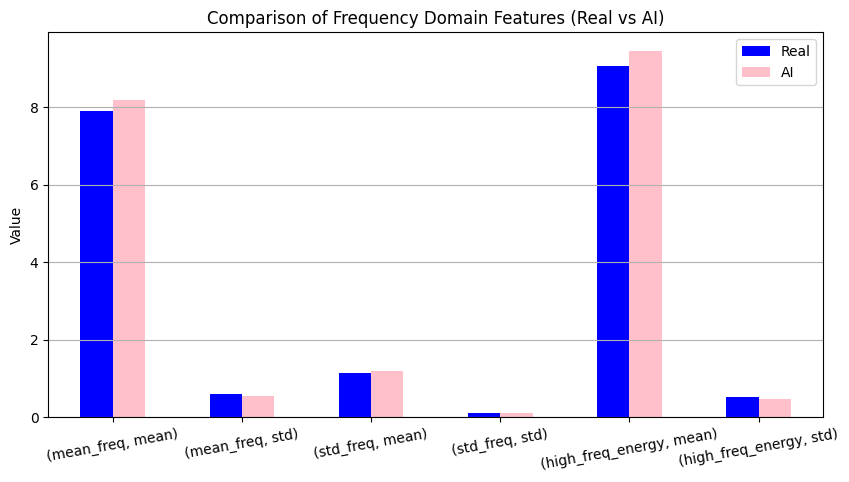

In [3]:
def compute_fft_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    # Compute 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift low frequencies to center
    magnitude_spectrum = np.log1p(np.abs(fshift))  # Log scale for better visualization

    # Extract frequency domain statistics
    mean_freq = np.mean(magnitude_spectrum)
    std_freq = np.std(magnitude_spectrum)
    high_freq_energy = np.mean(magnitude_spectrum[img.shape[0]//4 : 3*img.shape[0]//4, 
                                                   img.shape[1]//4 : 3*img.shape[1]//4])

    return mean_freq, std_freq, high_freq_energy

# Compute FFT features for all images
fft_features = {"label": [], "mean_freq": [], "std_freq": [], "high_freq_energy": []}

for img_path, label in zip(df_train["image_path"], df_train["label"]):
    features = compute_fft_features(img_path)
    if features:
        fft_features["label"].append(label)
        fft_features["mean_freq"].append(features[0])
        fft_features["std_freq"].append(features[1])
        fft_features["high_freq_energy"].append(features[2])

# Convert to DataFrame
df_fft = pd.DataFrame(fft_features)

# Compare mean frequency components for AI vs. Real images
stats_fft = df_fft.groupby("label").agg(["mean", "std"]).T
stats_fft.columns = ["Real", "AI"]

# Plot frequency statistics
stats_fft.plot(kind="bar", figsize=(10, 5), color=["blue", "pink"])
plt.title("Comparison of Frequency Domain Features (Real vs AI)")
plt.ylabel("Value")
plt.xticks(rotation=10)
plt.legend(["Real", "AI"])
plt.grid(axis="y")
plt.show()


## Interpretation of Results:
* Mean Frequency (mean: AI > Real, std: AI < Real):
    * AI-generated images have a higher mean frequency than real images.
    * The lower standard deviation for AI images suggests they have a more uniform frequency distribution, meaning less natural variation.
* Standard Deviation of Frequency Components (mean: AI > Real, std: AI < Real)
    * AI images have higher mean frequency variation than real images.
    * However, lower standard deviation indicates they might be lacking the rich, varied textures found in real images.
* High-Frequency Energy (mean: AI > Real, std: AI < Real)
    * AI images show more energy in high-frequency components, which is interesting.
    * This suggests AI-generated images might contain unnatural high-frequency details or artifacts, whereas real images exhibit more natural blending of frequencies.

## Potential Explanation
* AI images tend to be sharper or more uniform, which might explain the higher mean values across all metrics.
* Real images contain more organic noise, lighting variations, and textures, leading to a higher standard deviation in frequencies.

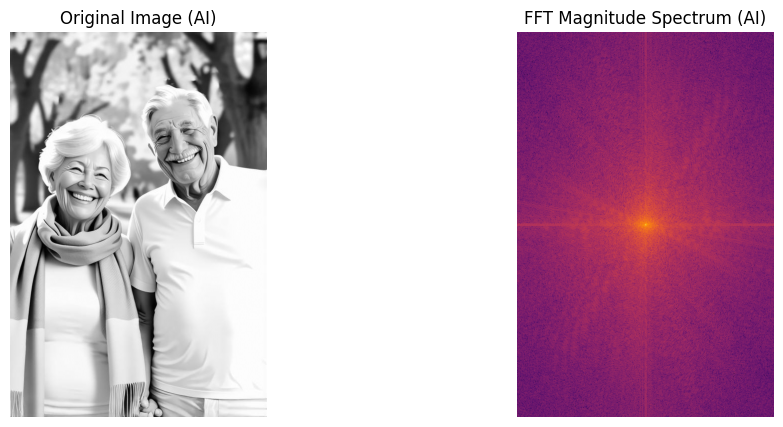

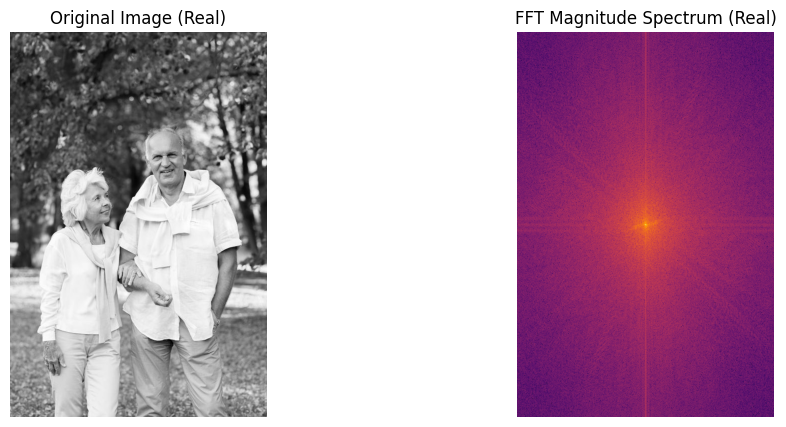

In [7]:

# Function to compute and visualize FFT
def plot_fft_spectrum(image_path, label):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if img is None:
        return
    
    # Compute 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to center
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # Log scaling for better visualization

    # Plot original image and its magnitude spectrum
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(f"Original Image ({label})")
    axes[0].axis("off")
    
    axes[1].imshow(magnitude_spectrum, cmap="inferno")
    axes[1].set_title(f"FFT Magnitude Spectrum ({label})")
    axes[1].axis("off")
    
    plt.show()

# Select one AI and one Real image
ai_image_path = df_train[df_train["label"] == 1]["image_path"].values[0]
real_image_path = df_train[df_train["label"] == 0]["image_path"].values[0]

# Plot for AI and Real images
plot_fft_spectrum(ai_image_path, "AI")
plot_fft_spectrum(real_image_path, "Real")

In [9]:

def compute_radial_profile(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    # Compute FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    
    # Compute distances from center
    h, w = magnitude_spectrum.shape
    center = (h // 2, w // 2)
    y, x = np.indices((h, w))
    distances = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)

    # Compute mean frequency magnitude per radial distance
    max_radius = np.max(distances)
    radial_profile = np.zeros(max_radius)
    counts = np.zeros(max_radius)

    for r in range(max_radius):
        mask = distances == r
        radial_profile[r] = np.mean(magnitude_spectrum[mask]) if np.any(mask) else 0
        counts[r] = np.sum(mask)

    return radial_profile

# Compute radial profiles for AI and Real images
ai_profiles = [compute_radial_profile(img) for img, lbl in zip(df_train["image_path"], df_train["label"]) if lbl == 1]
real_profiles = [compute_radial_profile(img) for img, lbl in zip(df_train["image_path"], df_train["label"]) if lbl == 0]

# Average the radial profiles
mean_ai_profile = np.mean(np.array(ai_profiles), axis=0)
mean_real_profile = np.mean(np.array(real_profiles), axis=0)

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.plot(mean_real_profile, label="Real", color="blue")
plt.plot(mean_ai_profile, label="AI", color="red")
plt.xlabel("Radial Distance from Center")
plt.ylabel("Mean Frequency Magnitude")
plt.title("Radial Frequency Distribution: AI vs. Real Images")
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 